In [28]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())



<br>

## Natural Language Processing
### :::: ELMO and BERT ::::

<br>

![figs/bert_elmo.png](figs/bert_elmo.png)

<br><br><br><br><br><br>


## Word meaning depends on context

- The vase broke.
- Dawn broke.
- The news broke.
- Sandy broke the world record.
- The burglar broke into the house.
- We broke even.
- I'm broke.

(examples courtest of Christopher Potts @ Stanford)

**word sense disambiguation**: clustering work tokens into those with the same meaning.

In [1]:
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

In [563]:
w2v.most_similar('bear', topn=10)

[('bears', 0.7837369441986084),
 ('grizzly', 0.5386144518852234),
 ('bore', 0.5122923851013184),
 ('bruin', 0.5050872564315796),
 ('Anna_Kozyreva', 0.48861247301101685),
 ('moose', 0.4850655496120453),
 ('grizzly_bear', 0.48331254720687866),
 ('sow_grizzly', 0.48160773515701294),
 ('yearling_cubs', 0.4791102707386017),
 ('griz', 0.4708966314792633)]

## Synthetic data

Returning to our toy example:

Two words appear near each other iff they start with the same letter:

> "All aardvarks ate apples."

> "Both bobcats broke bottles." 

We generated pairs of words and built a model to predict word 2 given word 1:

<br>

| $w_1$  | $w_2$     | 
|--------|-----------|
| ant    | aardvark  |
| alpaca | albatross |
| bee    | bison     |

<br>

<img src="figs/nn-ant.png" width=50%/>

<br>

Let's modify this to let words be context dependent.

Below, we generate synthetic data where:

- "a" input words produce "a" output words, no matter the context
- "b" input words produce "b" output words, most of the time
  - when "b" words appear near "c" words, they can sometimes produce "c" output words 

In [538]:
animals = ['aardvark', 'albatross', 'alligator', 'alpaca', 'anole', 'ant', 'anteater', 'antelope', 'ape', 'armadillo',
           'baboon', 'badger', 'barracuda', 'bat', 'bear', 'bee', 'bison', 'boar', 'bobcat', 'butterfly',
           'camel', 'caribou', 'cat', 'caterpillar', 'cheetah', 'chicken', 'chimp', 'cobra', 'cougar', 'crane']
vocab = {w: i for i,w in enumerate(animals)}
a_names = [a for a in animals if a[0] == 'a']
b_names = [b for b in animals if b[0] == 'b']
c_names = [c for c in animals if c[0] == 'c']


def make_animal_data():
    np.random.seed(42)
    # a + * -> a
    animal_data = pd.DataFrame(zip(np.random.choice(a_names, size=300), np.random.choice(animals, size=300), np.random.choice(a_names, size=300)),
                              columns=['word', 'context', 'output'])
    # b + * -> b
    animal_data = pd.concat((animal_data,
                           pd.DataFrame(zip(np.random.choice(b_names, size=300), np.random.choice(animals, size=300), np.random.choice(b_names, size=300)),
                              columns=['word', 'context', 'output'])))
    # b + c -> c
    animal_data = pd.concat((animal_data,
                           pd.DataFrame(zip(np.random.choice(b_names, size=300), 
                                            np.random.choice(c_names, size=300), np.random.choice(c_names, size=300)),
                              columns=['word', 'context', 'output'])))
    animal_data = animal_data.sample(frac=1, random_state=42)
    # remove where word==context==output
    animal_data = animal_data[~((animal_data.word == animal_data.context) | (animal_data.context == animal_data.output))]#.drop_duplicates()
    return animal_data
data = make_animal_data()
data

,word,context,output
70,antelope,caribou,aardvark
227,bobcat,caterpillar,caribou
231,aardvark,cougar,alpaca
288,baboon,anteater,badger
39,alpaca,bee,anole
...,...,...,...
71,anole,bobcat,ape
106,alligator,butterfly,antelope
260,butterfly,cheetah,cougar
135,barracuda,ant,boar


## Brainstorming 

What kind of network should we design to enable context dependencies?

<img src="figs/nn-hmm.png" width=50%/>

Somewhere we need to have a vector that represents the input word.

<br><br><br>

We have many options!

**linear embedding of concatenated embeddings**

<img src="figs/nn-linear.png" width=50%/>

\# parameters: $(30*2) + (30*2) + (4*2) + (2*30) =188$

In [549]:
import torch
import torch.nn as nn

class ContextModelLinear(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(ContextModelLinear, self).__init__()
        self.verbose = verbose
        self.embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        self.hidden = nn.Linear(2*embedding_size, embedding_size, bias=False)
        self.hidden2 = nn.Linear(embedding_size, vocab_size, bias=False)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, word, context):
        word_embedding = self.embedding(word)
        context_embedding = self.embedding(context)
        combined_embedding = self.hidden(torch.cat((word_embedding, context_embedding), dim=1))
        output = self.softmax(self.hidden2(combined_embedding))
        
        if self.verbose: print('word embedding\n', word_embedding,
                               '\ncontext embedding\n', context_embedding,
                               '\ncombined embedding\n', combined_embedding,
                               '\noutput\n', output)
        return output, combined_embedding

**bilinear embedding of embeddings**


<img src="figs/nn-bilinear.png" width=50%/>

\# parameters: $(30*2) + (30*2) + (4 * 2) + (2*30) = 188$

In [540]:
class ContextModelBilinear(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(ContextModelBilinear, self).__init__()
        self.verbose = verbose
        self.embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        self.bilinear = nn.Bilinear(embedding_size, embedding_size, embedding_size, bias=False)
        self.hidden = nn.Linear(embedding_size, vocab_size, bias=False)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, word, context):
        word_embedding = self.embedding(word)
        context_embedding = self.embedding(context)
        combined_embedding = self.bilinear(word_embedding, context_embedding)
        output = self.softmax(self.hidden(combined_embedding))
        
        if self.verbose: print('word embedding\n', word_embedding,
                               '\ncontext embedding\n', context_embedding,
                               '\ncombined embedding\n', combined_embedding,
                               '\noutput\n', output)
        return output, combined_embedding

## **linear embedding of concatenated words**

<img src="figs/nn-lincat.png" width=50%/>

\# parameters: $(60*2) + (2*30)=180$

In [575]:
class ContextModelCat(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(ContextModelCat, self).__init__()
        self.verbose = verbose
        self.embedding = nn.Linear(2*vocab_size, embedding_size, bias=False)
        self.hidden = nn.Linear(embedding_size, vocab_size, bias=False)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, word, context):
        combined_embedding = self.embedding(torch.cat((word, context), dim=1))
        output = self.softmax(self.hidden(combined_embedding))
        
        if self.verbose: print('\ncombined embedding\n', combined_embedding,
                               '\noutput\n', output)
        return output, combined_embedding

In [576]:
def vectorize_one(word, vocabulary):
    """ one-hot encoding"""
    tensor = torch.zeros(1, len(vocabulary))
    tensor[0][vocabulary[word]] = 1.0
    return tensor

def vectorize_batch(rows, vocabulary):
    """
    encode all examples in given list of rows in DataFrame.
    """
    return (torch.cat([vectorize_one(w, vocabulary) for w in rows.word]),
            torch.cat([vectorize_one(w, vocabulary) for w in rows.context]),
            torch.cat([vectorize_one(w, vocabulary) for w in rows.output]),
           )
    
# Compute forward pass for first example.
torch.random.manual_seed(42)
batch = vectorize_batch(data.iloc[:1], vocab)

print('linear')
linear_model = ContextModelLinear(len(vocab), embedding_size=2)
_ = linear_model(batch[0], batch[1])

print('\n\nbilinear')
bilinear_model = ContextModelBilinear(len(vocab), embedding_size=2)
_ = bilinear_model(batch[0], batch[1])

print('\n\nconcat')
cat_model = ContextModelCat(len(vocab), embedding_size=2)
_ = cat_model(batch[0], batch[1])

linear
word embedding
 tensor([[0.1072, 0.1475]], grad_fn=<MmBackward>) 
context embedding
 tensor([[-0.0214, -0.0705]], grad_fn=<MmBackward>) 
combined embedding
 tensor([[-0.0381,  0.0131]], grad_fn=<MmBackward>) 
output
 tensor([[0.0337, 0.0327, 0.0323, 0.0340, 0.0341, 0.0333, 0.0336, 0.0328, 0.0328,
         0.0326, 0.0339, 0.0331, 0.0331, 0.0339, 0.0325, 0.0334, 0.0340, 0.0333,
         0.0332, 0.0340, 0.0340, 0.0326, 0.0328, 0.0339, 0.0330, 0.0336, 0.0333,
         0.0332, 0.0338, 0.0335]], grad_fn=<SoftmaxBackward>)


bilinear
word embedding
 tensor([[-0.0700, -0.0274]], grad_fn=<MmBackward>) 
context embedding
 tensor([[-0.1448, -0.1719]], grad_fn=<MmBackward>) 
combined embedding
 tensor([[-0.0025,  0.0109]], grad_fn=<ViewBackward>) 
output
 tensor([[0.0333, 0.0334, 0.0333, 0.0334, 0.0332, 0.0332, 0.0335, 0.0334, 0.0332,
         0.0336, 0.0333, 0.0332, 0.0336, 0.0333, 0.0336, 0.0334, 0.0331, 0.0336,
         0.0335, 0.0334, 0.0332, 0.0332, 0.0332, 0.0332, 0.0332, 0.0335, 0.03

In [577]:
# what does bilinear do?
weight = bilinear_model.bilinear.weight
word = torch.tensor([1., 1.])
context = torch.tensor([2., 2.])
print('weight')
print(weight)
print()

print('output')
print(bilinear_model.bilinear(word, context))

# manual way: this is what bilinear computes
## mm == matrix multiplication
## .view(a,b) creates matrix with a rows and b columns from a vector of a*b values.
print('\n\nmanual output')
(torch.mm(word.view(1,2), torch.mm(weight[0], context.view(2,1))),
 torch.mm(word.view(1,2), torch.mm(weight[1], context.view(2,1))))

weight
Parameter containing:
tensor([[[-0.1872,  0.0756],
         [-0.1249, -0.2107]],

        [[ 0.4520,  0.6077],
         [-0.0700, -0.1583]]], requires_grad=True)

output
tensor([-0.8945,  1.6627], grad_fn=<ViewBackward>)


manual output


(tensor([[-0.8945]], grad_fn=<MmBackward>),
 tensor([[1.6627]], grad_fn=<MmBackward>))

In [578]:
# training loop.
from tqdm import tqdm
def train_context_model(model, data, vocab, epochs=20, learning_rate=0.1):
    torch.random.manual_seed(42)  # for reproducibility
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate) 
    model.verbose = False
    loss_val = []
    # main training loop
    for epoch in tqdm(range(epochs), total=epochs):
        optimizer.zero_grad() # reset all the gradient information
        words, contexts, labels = vectorize_batch(data, vocab)
        outputs, embeddings = model(words, contexts)
        loss = criterion(outputs, labels)
        loss.backward()      # computes all the gradients
        optimizer.step()     # update parameters
        loss_val.append(loss.item())

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

# get embedding for a word
def word2embedding(word, context, model, vocabulary):
    output, embedding = model(vectorize_one(word, vocabulary), vectorize_one(context, vocabulary))
    return embedding.detach().cpu().numpy()[0]

from adjustText import adjust_text
def plot_embeddings(animal_embeddings):
    plt.figure(figsize=(20,12))
    plt.scatter([e[0][0] for e in animal_embeddings],
                [e[0][1] for e in animal_embeddings])
    text = []
    for e in animal_embeddings:
        text.append(plt.annotate('%s-%s'% (e[1], e[2]), (e[0][0], e[0][1]), size=26))
    adjust_text(text, lim=2)
    plt.xlabel('first embedding dimension', size=26)
    plt.ylabel('second embedding dimension', size=26)
    plt.show()
    
    
test_words = [ ('bear', 'bee'), ('bear', 'bison'),
               ('bear', 'caribou'), ('bear', 'cougar'), 
               ('caribou', 'bear'), ('cougar', 'bear'),
               ('ant', 'bee'), ('ant', 'bear'), ('ant', 'caribou'), ('ant', 'cougar')
             ]

100%|██████████| 30/30 [00:00<00:00, 31.41it/s]


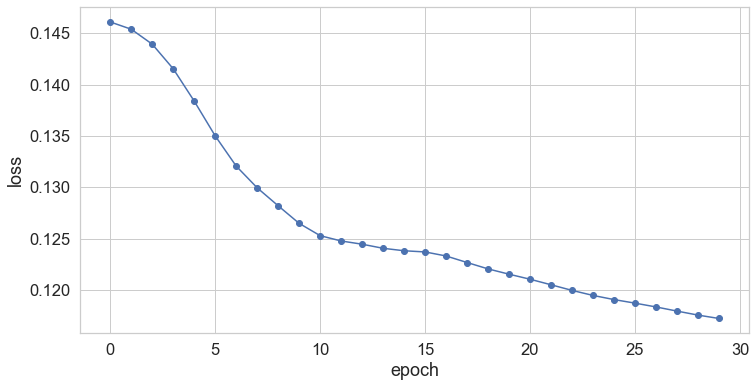

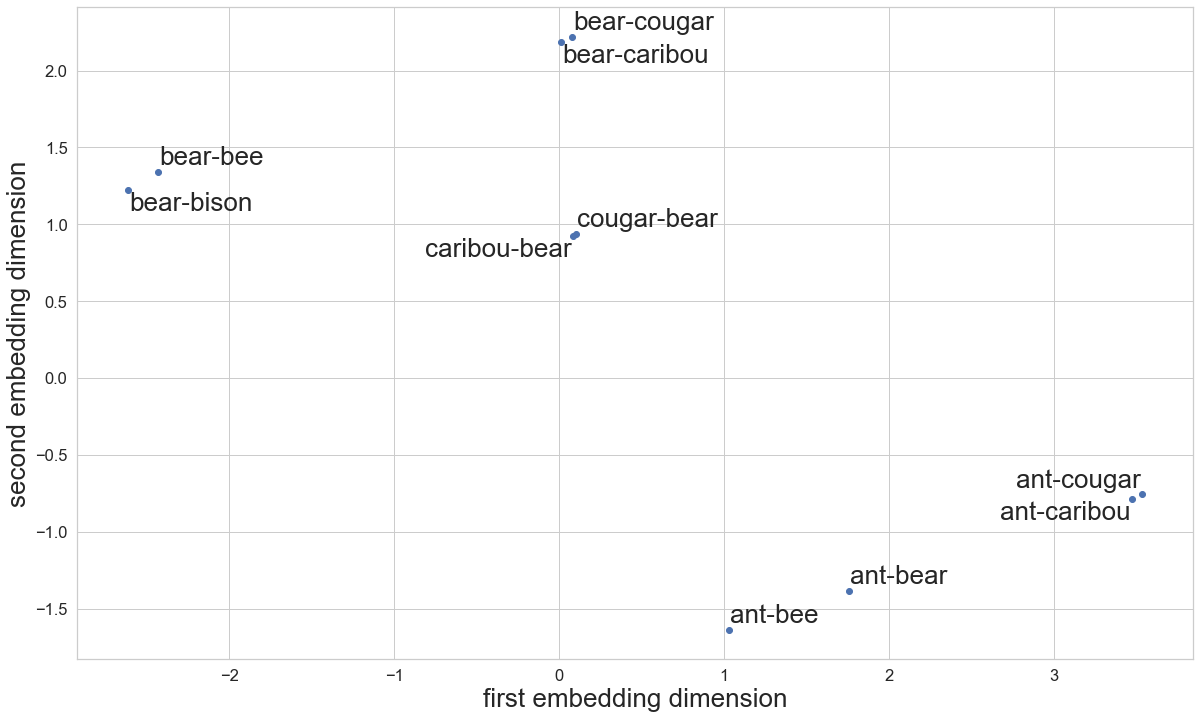

In [579]:
# train linear model
linear_model = train_context_model(ContextModelLinear(len(vocab), embedding_size=2), data, vocab, epochs=30, learning_rate=0.1)
plot_embeddings([(word2embedding(w,c, linear_model, vocab), w, c) for w,c in test_words])

100%|██████████| 30/30 [00:00<00:00, 30.81it/s]


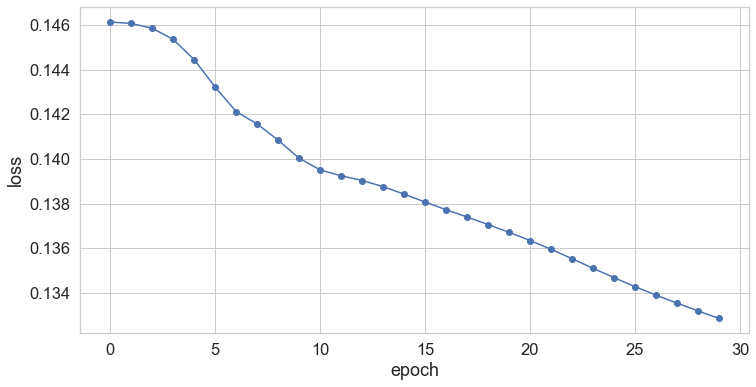

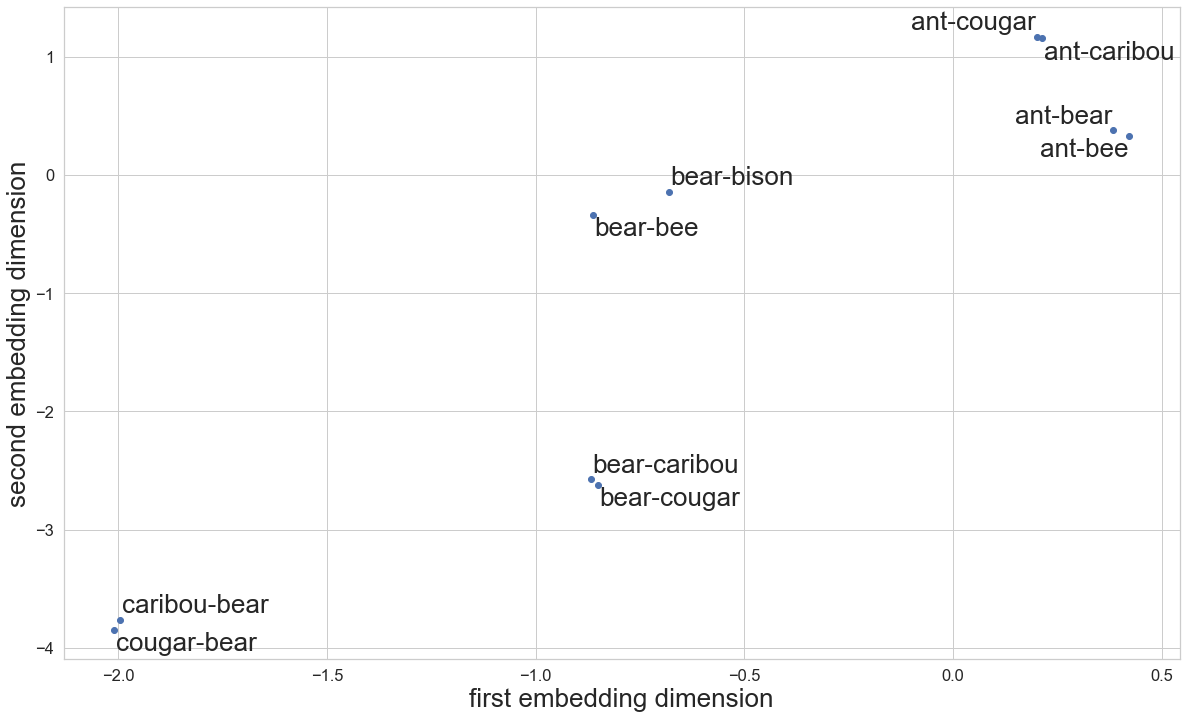

In [580]:
# train bilinear model
bilinear_model = train_context_model(ContextModelBilinear(len(vocab), embedding_size=2), data, vocab, epochs=30, learning_rate=0.1)
plot_embeddings([(word2embedding(w,c, bilinear_model, vocab), w, c) for w,c in test_words])

100%|██████████| 30/30 [00:00<00:00, 31.43it/s]


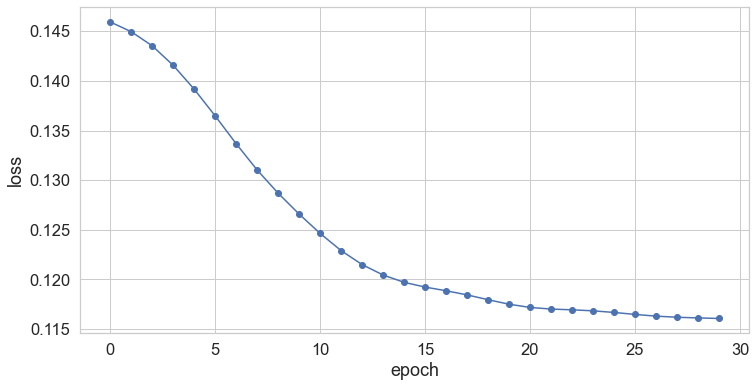

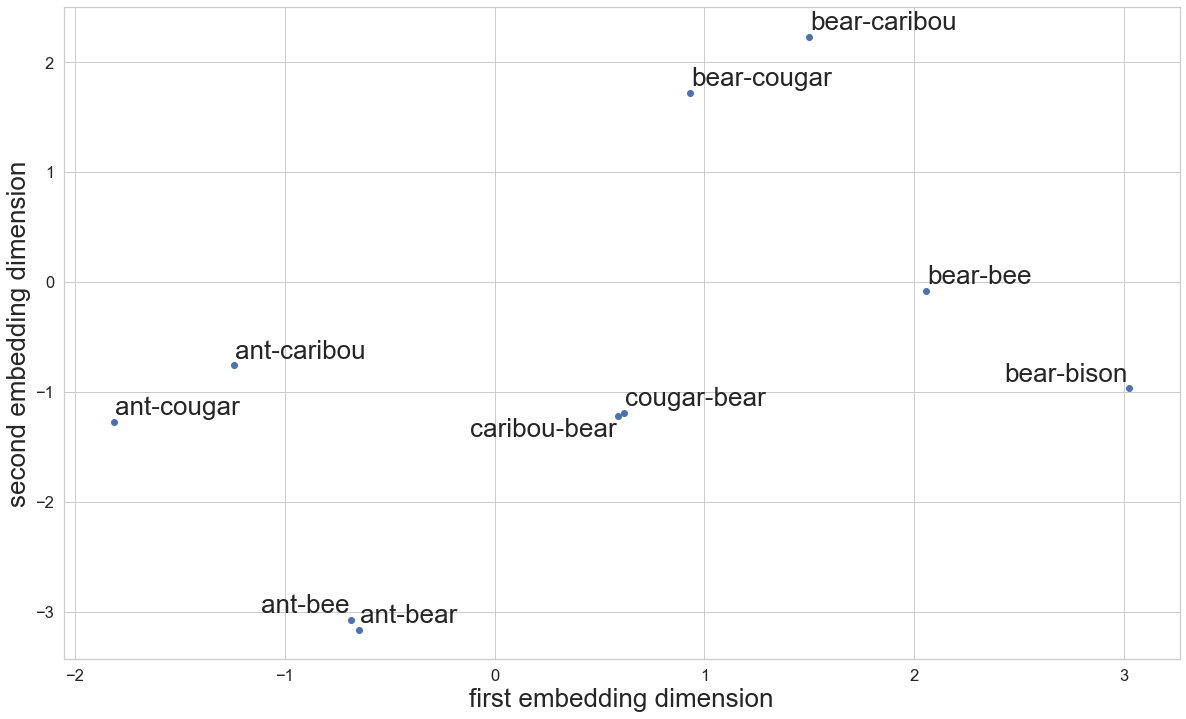

In [582]:
# train concat model
linear_model_cat = train_context_model(ContextModelCat(len(vocab), embedding_size=2), data, vocab, epochs=30, learning_rate=0.1)
plot_embeddings([(word2embedding(w,c, linear_model_cat, vocab), w, c) for w,c in test_words])

**observations:**

- In all models, the "b-b" pairs are separated from the "b-c" pairs.
- In `linear_model` and `linear_model_cat`, the "a-b" terms are more separated from the "a-c" terms, even though they shouldn't really be
  - in our synthetic data, "a" terms are context independent
- The `bilinear_model` has interaction terms (e.g., $w_1 c_1 \theta_{11}$), allowing more complex functions than the linear models, which only have terms like $w_1 \theta_{11}$ and $c_1 \theta_{31}$.


<br><br><br>

Our examples above are very simple ways to make word embeddings more context dependent. There has been a flurry of more complex methods in the past ~5 years.

Two popular ones are BERT and ELMO. We'll introduce them briefly here, then talk in more detail once we've covered sequence models.


## BERT
<img src="figs/bert.png" width=60%/>

## ELMO
<img src="figs/elmo.png" width=60%/>


[source](http://jalammar.github.io/illustrated-bert/)

## BERT tutorial

Here's a quick of example of how to extract token embeddings from BERT.

We use the [huggingface](https://github.com/huggingface/transformers) library to download a pre-trained BERT model.

In [492]:
# code: https://github.com/huggingface/transformers
# pip install transformers
# tutorial: http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#32-understanding-the-output
from transformers import BertModel, BertTokenizer
import logging
logger = logging.getLogger()
logger.level = logging.ERROR
hf_weights_name = 'bert-base-cased'
hf_tokenizer = BertTokenizer.from_pretrained(hf_weights_name)
hf_model = BertModel.from_pretrained(hf_weights_name, output_hidden_states=True)

In [521]:
text = "I can't bear to fight the big brown bear."
encoded_input = hf_tokenizer(text, return_tensors='pt')
output = hf_model(**encoded_input)
hidden_states = output[2]

In [522]:
# we need to use BERT's built-in tokenizer
# to ensure we can get the embeddings for each token.
tokenized_text = hf_tokenizer.tokenize("[CLS] " + text + " [SEP]")
# Map the token strings to their vocabulary indeces.
indexed_tokens = hf_tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))


[CLS]           101
I               146
can           1,169
'               112
t               189
bear          4,965
to            1,106
fight         2,147
the           1,103
big           1,992
brown         3,058
bear          4,965
.               119
[SEP]           102


In [523]:
# get the hidden embedding layers in a more convenient format.
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

token_embeddings = torch.stack(hidden_states, dim=0)

print(token_embeddings.size())

# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

print(token_embeddings.size())
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
print(token_embeddings.size())



Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 14
Number of hidden units: 768
torch.Size([13, 1, 14, 768])
torch.Size([13, 14, 768])
torch.Size([14, 13, 768])


In [524]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 14 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [14 x 768] tensor
    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 14 x 3072


In [550]:
# Stores the token vectors, with shape [14 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 14 x 768] tensor.
# For each token in the sentence...
for token in token_embeddings:
    # `token` is a [12 x 768] tensor
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)
    
print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 14 x 768


In [551]:
# `token_vecs` is a tensor with shape [24 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())


Our final sentence embedding vector of shape: torch.Size([768])


In [552]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 I
2 can
3 '
4 t
5 bear
6 to
7 fight
8 the
9 big
10 brown
11 bear
12 .
13 [SEP]


In [553]:
print('First 5 vector values for each instance of "bear".')
print('')
print("bear   ", str(token_vecs_sum[5][:5]))
print("bear   ", str(token_vecs_sum[10][:5]))
# as expected, bear is represented differently depending on context.

First 5 vector values for each instance of "bear".

bear    tensor([-0.8388, -1.1081, -6.0064,  2.9430, -1.2792], grad_fn=<SliceBackward>)
bear    tensor([ 1.8604, -0.8069,  0.1874, -0.8137, -3.1974], grad_fn=<SliceBackward>)


BERT is trained to predict words that are randomly masked in each training sentence.

We can thus use the model to "fill in the blank" of any sentence.

In [506]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-cased')
unmasker("Hello I'm a [MASK] model.")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'sequence': "Hello I'm a fashion model.",
  'score': 0.09019182622432709,
  'token': 4633,
  'token_str': 'fashion'},
 {'sequence': "Hello I'm a new model.",
  'score': 0.06350000947713852,
  'token': 1207,
  'token_str': 'new'},
 {'sequence': "Hello I'm a male model.",
  'score': 0.06228196248412132,
  'token': 2581,
  'token_str': 'male'},
 {'sequence': "Hello I'm a professional model.",
  'score': 0.04417278245091438,
  'token': 1848,
  'token_str': 'professional'},
 {'sequence': "Hello I'm a super model.",
  'score': 0.03326152265071869,
  'token': 7688,
  'token_str': 'super'}]

In [554]:
unmasker("The big grizzly [MASK].")

[{'sequence': 'The big grizzly bear.',
  'score': 0.3443209230899811,
  'token': 4965,
  'token_str': 'bear'},
 {'sequence': 'The big grizzly wolf.',
  'score': 0.052964359521865845,
  'token': 6164,
  'token_str': 'wolf'},
 {'sequence': 'The big grizzly bears.',
  'score': 0.036393191665410995,
  'token': 8807,
  'token_str': 'bears'},
 {'sequence': 'The big grizzly dog.',
  'score': 0.031312454491853714,
  'token': 3676,
  'token_str': 'dog'},
 {'sequence': 'The big grizzly man.',
  'score': 0.02647130750119686,
  'token': 1299,
  'token_str': 'man'}]

In [562]:
# Better to be wrong than dead?
unmasker("My professor is [MASK].")

[{'sequence': 'My professor is dead.',
  'score': 0.17697642743587494,
  'token': 2044,
  'token_str': 'dead'},
 {'sequence': 'My professor is right.',
  'score': 0.1753891408443451,
  'token': 1268,
  'token_str': 'right'},
 {'sequence': 'My professor is here.',
  'score': 0.04311561584472656,
  'token': 1303,
  'token_str': 'here'},
 {'sequence': 'My professor is gone.',
  'score': 0.04041293263435364,
  'token': 2065,
  'token_str': 'gone'},
 {'sequence': 'My professor is wrong.',
  'score': 0.016324695199728012,
  'token': 2488,
  'token_str': 'wrong'}]